#   Data Processing

![](../images/Module1/Data_Processing.png)


In [1]:
if (!require("BiocManager", quietly = TRUE))
    install.packages("BiocManager")
BiocManager::install("GEOquery")

Bioconductor version '3.14' is out-of-date; the current release version '3.15'
  is available with R version '4.2'; see https://bioconductor.org/install



'getOption("repos")' replaces Bioconductor standard repositories, see
'?repositories' for details

replacement repositories:
    CRAN: https://cran.r-project.org




Bioconductor version 3.14 (BiocManager 1.30.16), R 4.1.3 (2022-03-10)



Warning message:
"package(s) not installed when version(s) same as current; use `force = TRUE` to
  re-install: 'GEOquery'"


Old packages: 'ade4', 'AnnotationHub', 'BiocFileCache', 'BiocManager', 'blob',
  'broom', 'car', 'cli', 'clipr', 'clusterSim', 'colorspace', 'crayon', 'DBI',
  'dbplyr', 'desc', 'devEMF', 'doParallel', 'dplyr', 'DT', 'e1071', 'evaluate',
  'exactRankTests', 'ExperimentHub', 'extrafont', 'fansi', 'fitdistrplus',
  'flextable', 'FNN', 'formatR', 'future', 'future.apply', 'gdtools',
  'GenomeInfoDb', 'gert', 'glmnet', 'globals', 'glue', 'GPArotation', 'gplots',
  'gtools', 'gWidgets2tcltk', 'haven', 'httr', 'ie2misc', 'igraph', 'insight',
  'keras', 'km.ci', 'knitr', 'leiden', 'limma', 'lme4', 'lmtest', 'locfit',
  'magrittr', 'maptools', 'matrixStats', 'mclust', 'missForest', 'mnormt',
  'nloptr', 'officer', 'openssl', 'packageRank', 'parallelly', 'parsedate',
  'pillar', 'pkgload', 'pkgsearch', 'plyr', 'polynom', 'processx', 'proxy',
  'ps', 'psych', 'quantmod', 'quantreg', 'R.methodsS3', 'R.oo', 'R.utils',
  'R2HTML', 'randomForest', 'ranger', 'RColorBrewer', 'RcppArmadillo',
  'RcppEi

In [2]:
library("GEOquery")

Loading required package: Biobase



Loading required package: BiocGenerics




Attaching package: 'BiocGenerics'




The following objects are masked from 'package:stats':

    IQR, mad, sd, var, xtabs




The following objects are masked from 'package:base':

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min




Welcome to Bioconductor

    Vignettes contain introductory material; view with
    'browseVignettes()'. To cite Bioconductor, see
    'citation("Biobase")', and for packages 'citation("pkgname")'.




Setting options('download.file.method.GEOquery'='auto')



Setting options('GEOquery.inmemory.gpl'=FALSE)



In [3]:
# load series and platform data from GEO

gset <- getGEO("GSE48350", GSEMatrix =TRUE, AnnotGPL=TRUE)
if (length(gset) > 1) idx <- grep("GPL570", attr(gset, "names")) else idx <- 1
gset <- gset[[idx]]

# make proper column names to match toptable 
fvarLabels(gset) <- make.names(fvarLabels(gset))

# group membership for all samples
gsms <- paste0("XXXXXXX0XXX0XXX0XXX0XX0XX0XXX0XXXXXXX0XXX0XXXXX0XX",
               "X0XXX0XXXXX0X0XXX0XXX0XXX0XXXXX0XXX0XXXX0XX0XXXXX0",
               "XXX0XXX0XXX0XXXXX0XXX0XXX0XXX0XX0XXX0XXX0XXX0XXX0X",
               "XX0XXX0XXX0XXX0XX0XXXXX111111111111111XXXXXXXXXXXX",
               "XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX",
               "XXX")
sml <- strsplit(gsms, split="")[[1]]

# filter out excluded samples (marked as "X")
sel <- which(sml != "X")
sml <- sml[sel]
gset <- gset[ ,sel]

# log2 transformation
ex <- exprs(gset)
qx <- as.numeric(quantile(ex, c(0., 0.25, 0.5, 0.75, 0.99, 1.0), na.rm=T))
LogC <- (qx[5] > 100) ||
  (qx[6]-qx[1] > 50 && qx[2] > 0)
if (LogC) { ex[which(ex <= 0)] <- NaN
exprs(gset) <- log2(ex) }

# assign samples to groups and set up design matrix
gs <- factor(sml)
groups <- make.names(c("c","d"))
levels(gs) <- groups
gset$group <- gs
design <- model.matrix(~group + 0, gset)
colnames(design) <- levels(gs)

fit <- lmFit(gset, design)  # fit linear model

# set up contrasts of interest and recalculate model coefficients
cts <- paste(groups[1], groups[2], sep="-")
cont.matrix <- makeContrasts(contrasts=cts, levels=design)
fit2 <- contrasts.fit(fit, cont.matrix)

# compute statistics and table of top significant genes
fit2 <- eBayes(fit2, 0.01)
tT <- topTable(fit2, adjust="fdr", sort.by="B", number=250)

tT <- subset(tT, select=c("ID","adj.P.Val","P.Value","t","B","logFC","Gene.symbol","Gene.title"))
write.table(tT, file=stdout(), row.names=F, sep="\t")

Found 1 file(s)



GSE48350_series_matrix.txt.gz



ERROR: Error in lmFit(gset, design): could not find function "lmFit"


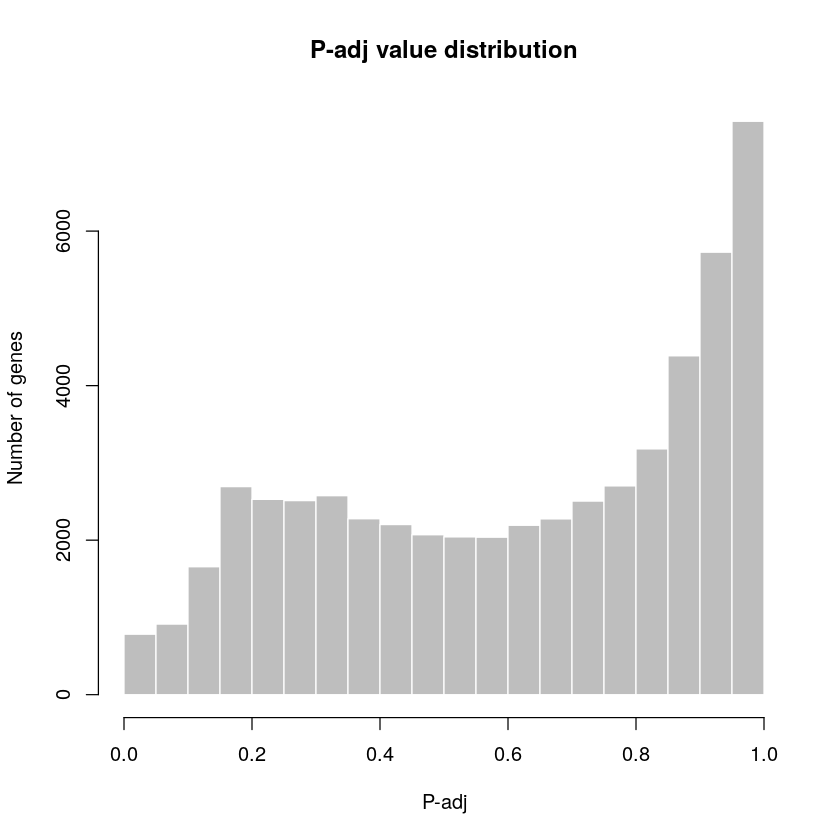

In [7]:
# Visualize and quality control test results.
# Build histogram of P-values for all genes. Normal test
# assumption is that most genes are not differentially expressed.
tT2 <- topTable(fit2, adjust="fdr", sort.by="B", number=Inf)
hist(tT2$adj.P.Val, col = "grey", border = "white", xlab = "P-adj",
     ylab = "Number of genes", main = "P-adj value distribution")

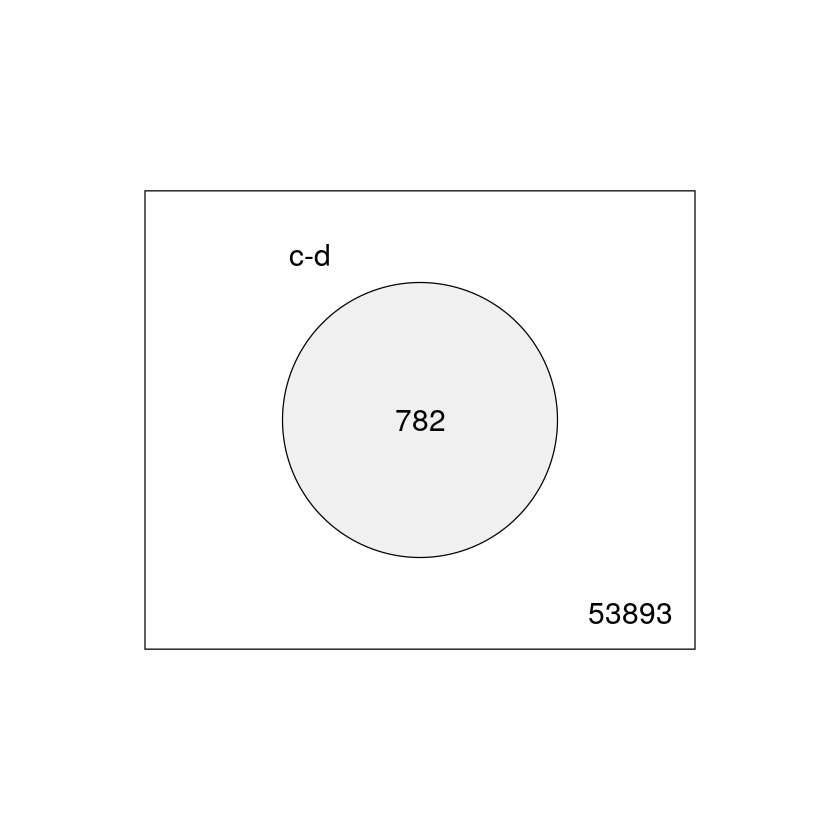

In [10]:
# summarize test results as "up", "down" or "not expressed"
dT <- decideTests(fit2, adjust.method="fdr", p.value=0.05)
# Venn diagram of results
vennDiagram(dT, circle.col=palette())

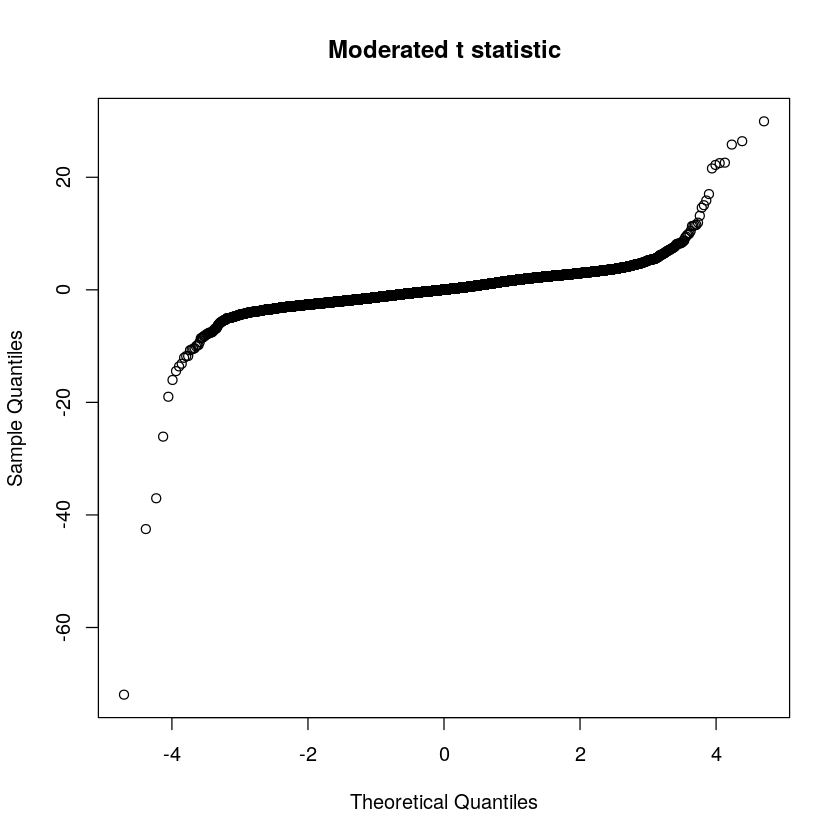

In [11]:
# create Q-Q plot for t-statistic
t.good <- which(!is.na(fit2$F)) # filter out bad probes
qqt(fit2$t[t.good], fit2$df.total[t.good], main="Moderated t statistic")

[1] "c-d"

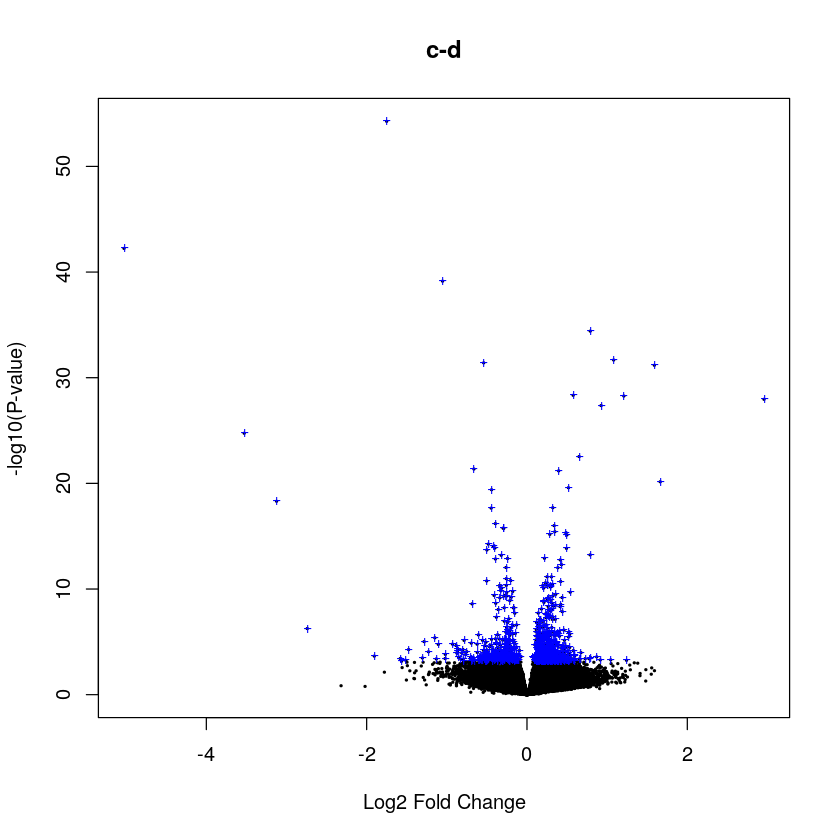

In [12]:
# volcano plot (log P-value vs log fold change)
colnames(fit2) # list contrast names
ct <- 1        # choose contrast of interest
volcanoplot(fit2, coef=ct, main=colnames(fit2)[ct], pch=20,
            highlight=length(which(dT[,ct]!=0)), names=rep('+', nrow(fit2)))

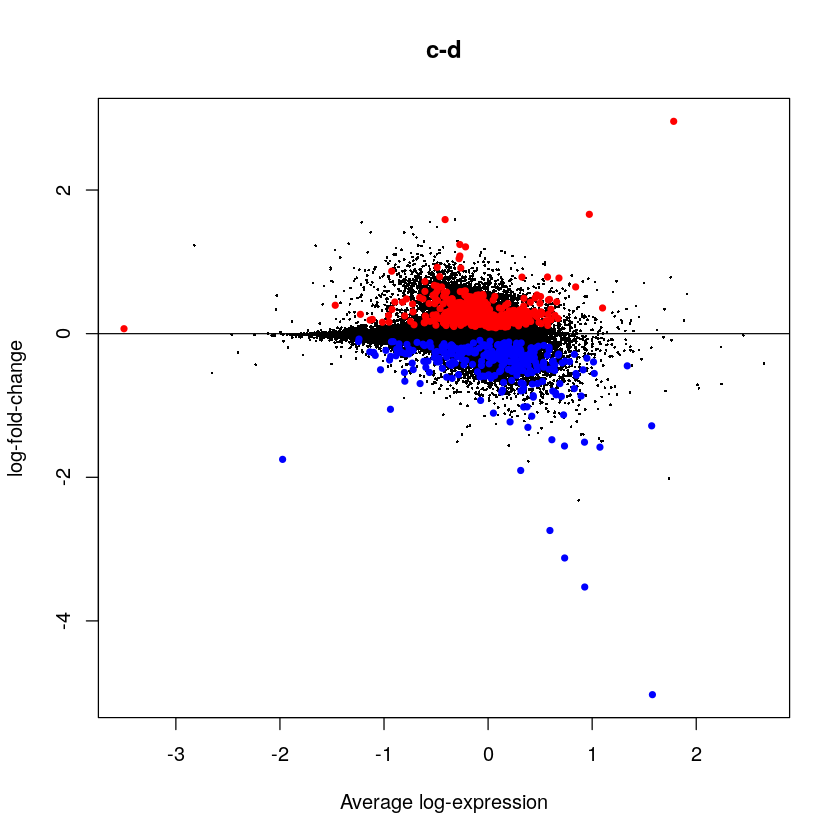

In [13]:
# MD plot (log fold change vs mean log expression)
# highlight statistically significant (p-adj < 0.05) probes
plotMD(fit2, column=ct, status=dT[,ct], legend=F, pch=20, cex=1)
abline(h=0)

In [14]:
# General expression data analysis
ex <- exprs(gset)

In [15]:
head(ex)


,GSM300173,GSM300177,GSM300181,GSM300186,GSM300189,GSM300192,GSM300196,GSM300204,GSM300208,GSM300214,⋯,GSM1176201,GSM1176202,GSM1176203,GSM1176204,GSM1176205,GSM1176206,GSM1176207,GSM1176208,GSM1176209,GSM1176210
1007_s_at,-0.9304071,-0.31429476,0.302564486,1.706508981,0.44324721,-0.35662310,-0.42414478,-0.68015019,0.70561100,0.23055657,⋯,0.29735707,1.0451786,0.35818266,0.86631591,-0.86054531,0.73855074,0.43443811,0.548127436,-0.2959882,0.54792328
1053_at,-0.1899698,-0.13598038,-0.303115126,0.003071112,-0.59434151,-0.30161908,0.04182821,-0.07260928,-0.29828630,-0.29855911,⋯,-0.24029072,-0.1255642,0.07094486,-0.15935824,0.07998875,-0.38857263,-0.09313018,-0.029009885,0.3229603,-0.01513872
117_at,-0.2784191,-0.34321870,-0.008780405,-0.040806964,3.44181211,0.02899129,0.32742570,0.04146729,-0.39414786,-0.30109524,⋯,-0.10819355,0.6173384,-0.09974673,0.59459326,0.13922468,-0.04004724,-0.03073124,0.805958790,0.3936756,-0.20228573
121_at,0.2035331,0.08515227,0.027424018,0.180686002,0.07046586,-0.11509540,0.22434064,0.18612576,0.01974077,0.10861143,⋯,0.01109913,-0.2074838,-0.10970414,0.41964341,0.10523085,-0.13914736,0.02295550,0.009695871,0.2261897,0.14256048
1255_g_at,0.5083751,-0.28938746,0.081224535,0.063953076,-0.31641582,0.60411337,0.25961200,0.03355860,-0.19762676,-0.28731400,⋯,0.57820991,-0.2487116,-0.18000081,0.04598304,0.07277371,-0.17741782,0.16908992,-0.080829885,3.2641306,0.15702094
1294_at,-0.3542675,0.01620918,0.065301945,0.933474441,-0.26148660,0.01263875,-0.62108366,-0.09775381,-0.40135476,0.04252303,⋯,0.45727226,1.3568780,-0.26581161,0.71747749,-0.18435227,-0.08382117,0.23467213,0.351081562,0.1501239,0.51403397
